# (실습) 케라스와 텐서플로우

## 텐서플로우 활용

순수 텐서플로우 API만을 이용하여 두 개의 층을 갖는 선형 분류 신경망을 구현한다.

In [1]:
import tensorflow as tf
import numpy as np

**데이터셋 생성**

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [2]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다. 
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [3]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [4]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

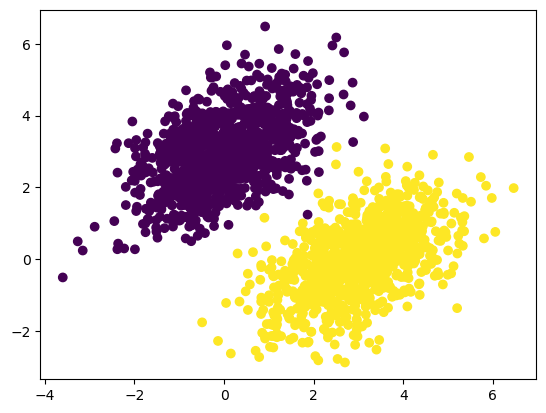

In [5]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**모델 지정**

아래 `dense()` 함수는 밀집층(dense layer)에서의 아핀 변환을 담당한다.

In [6]:
def dense(inputs, W, b, activation=None):
    outputs = tf.matmul(inputs, W) + b
    if activation != None:
        return activation(outputs)
    else:
        return outputs

두 개의 밀집층(dense layer)으로 구성된 순차 모델을 선언한다.

- 첫째 층: 유닛 5개
- 둘째 층: 유닛 1개

층을 구현하기 위해 먼저 각 층에 사용될 가중치 행렬과 편향 벡터를 초기화 한다.

- 첫째층의 가중치 행렬과 편향 벡터
    - 가중치 행렬: (2, 5) 모양의 텐서
    - 편향 벡터: (5,) 모양의 텐서

In [7]:
input_dim1 = 2    # 입력 샘플의 특성수 2개
output_dim1 = 5   # 첫째층의 유닛수 5개

# 가중치: 균등분포를 이용한 무작위 초기화
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))

# 편향: 0으로 초기화
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))

- 둘째층의 가중치 행렬과 편향 벡터
    - 가중치 행렬: (5, 1) 모양의 텐서
    - 편향 벡터: (1,) 모양의 텐서

In [8]:
input_dim2 = 5    # 입력 샘플의 특성수 5개. 첫째층의 유닛수와 동일.
output_dim2 = 1   # 하나의 값 출력

# 가중치: 무작위 초기화
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))

# 편향: 0으로 초기화
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

이제 모델을 선언할 수 있다.

In [9]:
def model(inputs):
    outputs = dense(inputs, W1, b1, tf.nn.relu) # 첫째 층 아핀 변환. relu 활성화 함수 사용
    outputs = dense(outputs, W2, b2)    # 둘째 층 아핀 변환
    return outputs

**손실 함수 선언**

손실값은 타깃과 예측값 사이의 오차의 제곱의 평균값으로 한다.

In [10]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**훈련 스텝**

하나의 배치에 대해 예측값을 계산한 후에 손실 함수의 그레이디언트를 이용하여 가중치와 편향을 업데이트한다. 
배치를 전체 데이터셋으로 지정하기에 하나의 스텝은 하나의 에포크에 해당한다.

In [11]:
learning_rate = 0.1

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)

    return loss

**훈련 실행**

총 100번의 에포크를 실행한다.
10번의 에포크마다 손실값을 출력하도록 하였다.

In [12]:
for step in range(100):
    loss = training_step(inputs, targets)
    if step % 10 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.7746
Loss at step 10: 0.0414
Loss at step 20: 0.0307
Loss at step 30: 0.0282
Loss at step 40: 0.0266
Loss at step 50: 0.0255
Loss at step 60: 0.0246
Loss at step 70: 0.0239
Loss at step 80: 0.0232
Loss at step 90: 0.0227


손실값이 계속해서 줄어들고 있기에 훈련을 더 하는 게 좋다.
아래 코드는 1000번 더 반복 훈련한다.
가중치와 편향이 초기화되지 않고 이어서 업데이트됨에 주의한다.
손실값은 대신 100번 훈련할 때마다 출력되도록 하였다.

In [13]:
for step in range(1001):
    loss = training_step(inputs, targets)
    if step % 100 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.0221
Loss at step 100: 0.0188
Loss at step 200: 0.0169
Loss at step 300: 0.0156
Loss at step 400: 0.0149
Loss at step 500: 0.0145
Loss at step 600: 0.0142
Loss at step 700: 0.0139
Loss at step 800: 0.0137
Loss at step 900: 0.0135
Loss at step 1000: 0.0134


## 예측

In [14]:
predictions = model(inputs)

예측 결과를 확인하면 다음과 같다.
예측값이 0.5보다 클 때 양성으로 판정한다.

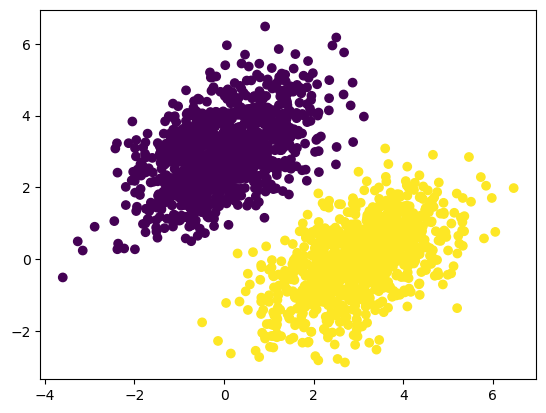

In [15]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

**문제 1**

위 코드는 학습과정에서 전체 데이터셋을 하나의 배치로 사용한다.
배치 크기를 예를 들어 16, 32, 64, 128 등으로 지정하여 
에포크가 여러 개의 스텝으로 구성되도록 코드를 수정한 후에 훈련을 진행하여 최선의 모델을 구현하라.

**문제 2**

예측 정확도(accuracy)를 평가지표(`metrics`)로 지정하여 훈련 에포크마다 손실값과 함께 출력하는 기능을 추가하라. 
단, 예측값이 0.5 이상이면 양성, 아니면 음성으로 판정하며,
에포크의 손실값과 정확도는 스텝별로 계산된 손실값과 정확도의 평균값을 사용한다.

**문제 3**

위 코드는 두 개의 `dense` 층을 사용한다.
세 개의 `dense` 층을 사용하도록 모델을 지정하고 훈련시키는 과정을 구현하라.

힌트: 

- `model` 선언과 `training_step()` 함수 선언에서 수정이 요구된다.
- 마지막 출력층을 제외한 두 개의 은닉층은 `relu()` 활성화 함수를 사용한다.

**문제 4**

세 개의 `dense` 층을 사용했을 때 마지막 층을 제외한 두 개의 은닉층에서의 유닛 개수를 몇 개로 지정할 때
최적의 모델을 구현할 수 있는지 확인하라.

## [TensorFlow Playground](https://playground.tensorflow.org)

[TensorFlow Playground](https://playground.tensorflow.org)에서 분류와 회귀 모델의 학습과정을 살펴 보면서 
문제를 해결하는 최선의 모델을 찾고자 한다.
그런 다음에 아래 요소들에 적절한 값이 선택된 이유를 (추정해서) 설명할 수 있어야 한다.

- 특성(features) 선택
- 학습률(learning rate)
- 활성화 함수(activation function)
- 규제(regularization)와 규제율(regularization rate)
- 훈련셋(training set)대 테스트셋(test set) 비율
- 배치 크기(batch size)
- 은닉층(hidden layer)과 유닛(unit 또는 neuron) 수

**모델 A**

아래 그림은 음성 데이터(주황색)와 양성 데이터(파랑색)를 분류하는 목적으로 훈련 시키려 하는 심층 신경망 모델을 보여준다.

- 입력 특성: $\mathrm{x}_1$과 $\mathrm{x}_2$ 두 개
- 은닉층(hidden layer) 2개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 2개
- 출력값 1개: 양성/음성 여부 판단
    
유닛과 유닛을 연결하는 파란선/주황선은 각각 양의 가중치와 음의 가중치 값을 가리킨다.
선의 두께는 가중치의 절댓값에 해당한다.
즉, 두꺼운 선일 수록 해당 가중치가 출력 유닛에 저장되는 값을 계산할 때 기여도가 보다 크다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a07.jpg" style="width:700px;"></div>


위 사진의 모델을 훈련시키면 다음과 같이 결과가 나온다.

- 훈련 에포크: 505
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.003
    - 훈련셋에 대한 손실값: 0.001



<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a05.png" style="width:700px;"></div>


**모델 B**

반면에 하나의 은닉층만 사용하면 결과가 다르게 나온다.

- 은닉층(hidden layer) 1개
    - 첫째 은닉층: 유닛 4개
- 훈련 에포크: 511
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.016
    - 훈련셋에 대한 손실값: 0.004

즉, 훈련된 모델의 성능(평가지표)가 두 개의 은닉층을 사용하는 모델보다 나쁘다.
특히 테스트셋에 대한 성능이 훈련셋에 대한 성능보다 많이 떨어져서
과대적합(overfitting)이 보다 심하게 발생했다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a04.png" style="width:700px;"></div>


**모델 C**

은닉층을 아래 그림에서처럼 세 개로 늘리면 성능이 두 개의 은닉층을 사용할 때보다 성능이 좀 더 좋아진다.

- 은닉층(hidden layer) 3개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 3개
    - 둘째 은닉층: 유닛 2개
- 훈련 에포크: 234
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.001
    - 훈련셋에 대한 손실값: 0.001

에포크가 234로 이전보다 훨씬 빠르게 좋은 분류 모델을 학습시킨다. 
은닉층을 늘린다고 무조건 좋아지는 것은 일반적으로 아니지만 이 경우엔 최선의 결과를 낳았다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a06.png" style="width:700px;"></div>


## 케라스 활용

케라스를 이용하여 앞서 소개한 모델 A, 모델 B, 모델 C를 직접 구성해서
훈련시키고자 한다.
훈련에 사용되는 데이터셋은 아래 코드를 이용하여 생성한다.

In [1]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt

[`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) 함수를 이용하여 모델 학습에 사용될 데이터셋을 생성한다.

- `datasets`: 입력 데이터셋. (2000, 2) 모양의 텐서. 2000개의 데이터 샘플 포함. 양성, 음성 각각 1000개
- `targets`: 타깃 데이터셋. 0과 1로 구성된 (2000,) 모양의 텐서. 0은 음성, 1은 양성.

In [2]:
from sklearn.datasets import make_circles
dataset, targets = make_circles(2000, noise=0.1, factor=0.2)

`dataset`은 (2000, 2) 모양의 텐서다. 
즉, 한 개의 데이터 샘플은 두 개의 특성을 갖는다.

In [3]:
print("모양: ", dataset.shape)
print("첫 5개 데이터:", dataset[:5], sep='\n')

모양:  (2000, 2)
첫 5개 데이터:
[[-0.18577565  0.19973669]
 [ 0.70876214  0.59646912]
 [-0.7811663   0.60130235]
 [-0.14894485  0.02115265]
 [-0.29590401 -0.9761957 ]]


2000개의 샘플의 양성/음성 여부는 (2000, 1) 모양의 `targets` 텐서에 저장되어 있으며
무작위로 지정되어 있다.
예를 들어 첫 5개 샘플의 양성/음성 여부는 다음과 같다.
0은 음성을, 1은 양성을 가리킨다.

In [4]:
print("타겟 모양: ", targets.shape)
print("타겟:", targets[:5], sep='\n')

타겟 모양:  (2000,)
타겟:
[1 0 0 1 0]


양성은 파란색, 음성은 주황색으로 표시한 데이터 산점도는 다음과 같다.

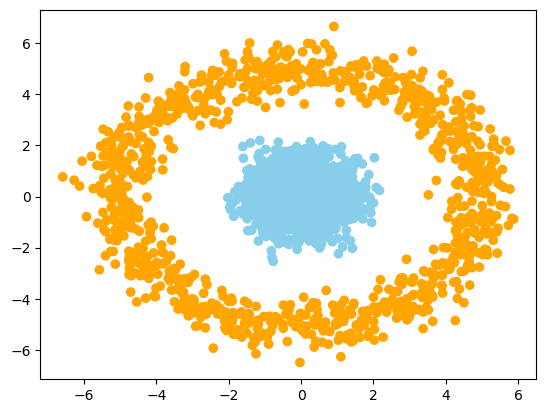

In [5]:

plt.scatter(dataset[:,0]*5, dataset[:,1]*5, c=['orange' if i==0 else 'skyblue' for i in targets])
plt.show()

케라스를 이용하여 "모델 A"를 구성한 다음에 위 데이터셋을 이용하여 훈련시키고자 한다.
먼저, `targets`의 모양을 다음과 같이 변환시킨다.
이유는 케라스 모델은 타깃 데이터셋도 2차원 텐서를 요구하기 때문이다.

신경망 모델은 데이터 샘플 별로 여러 종류의 값을 동시에 예측할 수 있기에
하나의 샘플에 대한 예측값을 종류별 예측값으로 구성된 벡터로 계산한다.
여기서는 데이터 샘플 별로 양성/음성 여부에 대해서만 예측하기 때문에 
한 샘플에 대한 예측값은 길이가 1인 벡터이다.
따라서 타깃셋은 (2000, 1) 모양의 텐서이어야 한다.

In [6]:
targets = targets.reshape(-1,1)
targets

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]], dtype=int64)

모델 A를 신경망 모델 `model_A`로 구성하면 다음과 같다.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model_A = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 첫째 은닉층
    layers.Dense(2, activation="tanh"),   # 둘째 은닉층
    layers.Dense(1, activation="sigmoid") # 출력층
    ])

`model_A` 를 아래 옵션을 이용하여 컴파일한다.

- 옵티마이저: `rmsprop`
- 손실: `binary_crossentropy` (이진 분류 용도의 손실 함수 지정)
- 평가지표: `accuracy` (정확도 평가)

In [8]:
model_A.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

50대 50의 비율로 훈련용 데이터셋과 타깃셋인 `x_train`, `y_train`과 
테스트용 데이터셋과 타깃셋 `x_test`, `y_test`를 지정한다.

In [9]:
x_train, y_train = dataset[:1000], targets[:1000]
x_test, y_test = dataset[1000:], targets[1000:]

모델을 훈련시킨다. 
`fit()` 메서드의 반환값은 훈련이 잘 된 모델의 정보를 담고 있는 `History` 객체이다.

In [10]:
history = model_A.fit(x_train, y_train, epochs=30, batch_size=10)

Epoch 1/30
100/100 [==============================] - 1s 1ms/step - loss: 0.6927 - accuracy: 0.6460
Epoch 2/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6909 - accuracy: 0.6860
Epoch 3/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6881 - accuracy: 0.6820
Epoch 4/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6837 - accuracy: 0.6540
Epoch 5/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6777 - accuracy: 0.6410
Epoch 6/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6702 - accuracy: 0.6530
Epoch 7/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6616 - accuracy: 0.6540
Epoch 8/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6521 - accuracy: 0.6590
Epoch 9/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6422 - accuracy: 0.6580
Epoch 10/30
100/100 [==============================] - 0s 1ms/step - loss: 0.6314 - accuracy: 0.6590

`History` 객체는 훈련된 모델의 다양한 정보를 저장한다.
예를 들어 `model` 속성은 훈련된 모델을 저장한다.
아래 코드는 훈련된 모델이 `Sequential` 모델임을 확인해준다.

In [11]:
type(history.model)

keras.src.engine.sequential.Sequential

케라스의 모든 모델은 `keras.Model` 클래스를 상속한다.

In [12]:
isinstance(history.model, keras.Model)

True

따라서 모델에 사용된 층의 구성을 확인기 위해
`Model` 클래스의 인스턴스 메서드인 `summary()` 메서드를 이용할 수 있다.

In [13]:
history.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (10, 4)                   12        
                                                                 
 dense_1 (Dense)             (10, 2)                   10        
                                                                 
 dense_2 (Dense)             (10, 1)                   3         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


위 결과가 설명하는 바는 다음과 같다.

- `Layer (type)` 열: 각 층에 사용된 층의 이름과 종류. 이름을 별도로 지정하지 않으면 자동으로 지정된다.
- `Output Shape` 열: 각 층에서 생성되는 출력 텐서의 모양. 
    예를 들어 (10, 4)에서 10은 배치 크기를, 4는 네 개의 유닛 개수. 즉 원래 2개의 특성을 갖는 데이터 샘플 각각을
    4개의 특성을 갖는 데이터 샘플로 변환.
- `Param`: 각 층에서 학습되는 파라미터(가중치와 편향)의 개수. 계산법은 다음과 같음.
    - 첫째 층의 파라미터: `2*4 + 4 = 12`
    - 둘째 층의 파라미터: `4*2 + 2 = 10`
    - 셋째 층의 파라미터: `2*1 + 1 = 3`

기타 요소는 다음과 같다.

- `Toral params`: 파라미터 수의 총합. `12 + 10 + 3 = 25`
- `Trainable params`: 훈련되는 파라미터 수의 총합. `12 + 10 + 3 = 25`
- `Non-trainable params`: 훈련되지 않는 파라미터 수의 총합. `0 + 0 + 0 = 0`. 
    즉, 위 모델은 훈련되지 않는 파라미터 사용하지 않음.


`history.model`이 가리키는 모델과 `model_A` 동일한 모델을 가리킨다.
이유는 `model_A.fit()` 메서드가 실행되는 동안 `model_A`가 훈련되는데,
이는 지정된 가중치 행렬과 편향 벡터가 모델 자체에서 업데이트 되는 것을 의미하기 때문이다.

실제로 테스테셋의 처음 5개 데이터 샘플에 대한 예측값이 동일함을 아래 코드로 확인할 수 있다.

In [14]:
model_A.predict(x_test[:5])

1/1 [==============================] - 0s 131ms/step


array([[0.45474806],
       [0.76844394],
       [0.7797085 ],
       [0.25503737],
       [0.7839991 ]], dtype=float32)

In [15]:
history.model.predict(x_test[:5])

1/1 [==============================] - 0s 26ms/step


array([[0.45474806],
       [0.76844394],
       [0.7797085 ],
       [0.25503737],
       [0.7839991 ]], dtype=float32)

`History` 객체의 `params` 인스턴스 속성은 `fit()` 메서드가 모델 훈련에 사용되는
하이퍼파라미터를 저장한다.
아래 코드는 30번의 에포크와 스텝의 수를 보여준다.
참고로 스텝은 훈련셋의 크기와 배치크기에 의해 자동 결정된다.
여기서 100인 이유는 훈련셋의 크기가 1000이고 배치 크기가 10 기에
총 `1000/10 = 100` 번의 스텝이 한 번의 에포크 동안 실행된다.
`verbose`는 모델 훈련 과정중에 에포크별로 진행상황과 평가 결과를 어떻게 보여줄 것인가를 지정한다.
별 이유가 없다면 기본값을 굳이 바꿀 필요는 없다.

In [16]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 100}

`History` 객체의 `history` 속성은 훈련 과정에서 에포크 단위로 계산된
훈련셋과 검증셋에 대한 손실값(loss)과 평가지표를 저장한 사전 객체를 가리킨다.
여기서는 검증셋은 지정되지 않았고, 평가지표로 정확도(accuracy) 하나만 사용하였기에
훈련셋에 대한 손실값(loss)과 정확도(accuracy)만 에포크 단위로 저장한다.

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

예를 들어 에포크 별 훈련셋에 대한 손실값의 변화는 다음과 같다.

In [18]:
history.history['loss']

[0.6927065253257751,
 0.6909409761428833,
 0.6881136298179626,
 0.6837040781974792,
 0.6777017712593079,
 0.6701806783676147,
 0.6616257429122925,
 0.6521036624908447,
 0.6422209739685059,
 0.6313847899436951,
 0.6203140616416931,
 0.608655571937561,
 0.5964779257774353,
 0.5843089818954468,
 0.5722936987876892,
 0.5603699088096619,
 0.5486469864845276,
 0.5377382636070251,
 0.5269066691398621,
 0.516233503818512,
 0.5057471990585327,
 0.49612852931022644,
 0.4869464039802551,
 0.47779202461242676,
 0.4694082736968994,
 0.4614202678203583,
 0.4538676142692566,
 0.446422815322876,
 0.43919622898101807,
 0.43275609612464905]

에포크 별 훈련셋에 대한 정확도의 변화는 다음과 같다.

In [19]:
history.history['accuracy']

[0.6460000276565552,
 0.6859999895095825,
 0.6819999814033508,
 0.6539999842643738,
 0.640999972820282,
 0.652999997138977,
 0.6539999842643738,
 0.6589999794960022,
 0.6579999923706055,
 0.6589999794960022,
 0.6970000267028809,
 0.7570000290870667,
 0.7889999747276306,
 0.8029999732971191,
 0.8199999928474426,
 0.8309999704360962,
 0.8360000252723694,
 0.847000002861023,
 0.8519999980926514,
 0.8619999885559082,
 0.8640000224113464,
 0.8619999885559082,
 0.8690000176429749,
 0.8700000047683716,
 0.8700000047683716,
 0.8740000128746033,
 0.8730000257492065,
 0.8740000128746033,
 0.8769999742507935,
 0.875]

**문제 1**

모델 B를 신경망 모델 `model_B`로 구성한 다음 훈련시킨 결과를 설명하라.

**문제 2**

모델 C를 신경망 모델 `model_C`로 구성한 다음 훈련시킨 결과를 설명하라.

**문제 3**

`model_A`, `model_B`, `model_C`의 성능을 비교하라.

**문제 4**

아래 설정을 변경하면서 최고 성능의 모델을 구현하라.

- 층과 유닛의 개수
- 훈련셋과 테스트셋의 비율
- 배치 크기
- 학습률
- 규제와 규제율
- 활성화 함수
- 에포크

In [106]:
model = None

## 캘리포니아 주택가격 데이터셋

**문제 1**

캘리포니아 주택가격 데이터셋을 이용한 회귀 심층 신경망 모델을 구성하고 훈련시켜라.
단, `Sequential` 모델과 `Dense` 층 이외에 다른 종류의 모델과 층은 절대로 이용하지 않는다.
또한 캘리포니아 데이터셋과 모델 구성에 대해서는 인터넷 자료를 참고하며,
모델을 구성할 때 다음 사항에 주의한다.

- 회귀 모델의 마지막 출력층은 활성화 함수를 사용하지 않는다.
- 모델 컴파일 요소(옵티마이저, 손실 함수, 평가지표) 또한 인터넷 자료를 참고한다.
- 은닉층의 활성화 함수는 `relu` 함수를 이용한다.


힌트: 아래 사이트를 참고한다.

- https://www.kaggle.com/code/saurav9786/ann-with-tensorflow-2-0-to-predict-housing-prices